# DNN for Number Recognition 
Author: Tom Schubert

### Quellen:
1. https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
2. pytorch docs

In [74]:

import torch
import torchvision
import matplotlib.pyplot as plt

# Hyperparameters

In [75]:
momentum = 0.9      
epochs = 8           # Wie oft alle Images durch den Trainingsprozess laufen müssen
learning_rate = 0.01   # Linearer Faktor in Gradient Decent zum skaliern der Gradientenänderung
# Defines how many pictures are getting processed parallel (before backpropagation)
batch_size_train = 128   # batch size for Training
batch_size_test = 1000  # batch size for testing    https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu

log_interval = 5

# for random functions generate seed
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Download Dataset with specified Downloader

In [76]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/DNN/', train=True, download=True,
                              # Transdormation Pipeline  https://pytorch.org/vision/stable/transforms.html
                             transform=torchvision.transforms.Compose([
                               # Scale Image from 0-255 to 0-1  https://discuss.pytorch.org/t/how-does-transforms-totensor-work-and-computation-of-mean-and-std-values/9085
                               torchvision.transforms.ToTensor(),
                               # the mean=0, stdev=1 scaling, (Normalizing)  https://www.youtube.com/watch?v=dXB-KQYkzNU&ab_channel=deeplizard
                               torchvision.transforms.Normalize(
                                 (0.13195264339447021,), (0.30903369188308716,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('./data/DNN/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.13195264339447021,), (0.30903369188308716,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# Data Visualisation

In [77]:
train_data=enumerate(train_loader)  #enumerate over Trainingsdata
test_data=enumerate(test_loader)    # enumerate over Testdata

batch_batch_index, (img_train_data,label_train_data) = next(train_data)   # Get the first batch of the training data
batch_test_index, (img_test_data,label_test_data) = next(test_data)        # Get the first batch of the test data

torch.Size([128, 20])


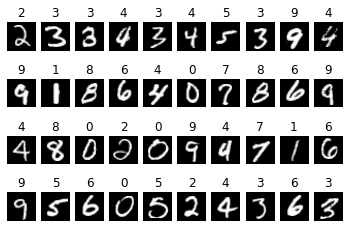

In [78]:
figure = plt.figure()
print(torch.randn(128, 20).shape)
num_of_images = 40
for index in range(1, num_of_images+1):
    plt.subplot(4, 10, index)
    plt.axis('off')
    plt.title(f'{label_test_data[index]}')
    plt.imshow(img_test_data[index].squeeze(), cmap='gray') # squeeze() removes single dimensions from shape 1 (numpy function)

# DNN

In [79]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from DNN import DNN

#           Definition of DNN-Modell
<center><img src="img/DNN_Architecture.png"/></center>


In [80]:
# CNN Klasse
dnn = DNN()
# Stochastic gradient descent
# USe  network.cuda() to transport params to gpu
# Optimizes the Network with Stochastic Gradient Descent
optimizer = optim.SGD(dnn.parameters(), lr=learning_rate,momentum=momentum)

# Training Definition

In [81]:
# Store the losses calculated while training 
train_losses = []
# Store how many images got trained (make a list for plotting)
train_counter = []
# Store the losses calculated while testing 
test_losses = []
# Store how many images got testes (make a list for plotting)
test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]

In [82]:
def train(epoch, model, train_loader, optimizer):
  model.train()
  progress_bar=tqdm(train_loader)
  for batch_idx, (data, target) in enumerate(progress_bar):
    # gradient auf 0 zurücksetzten
    optimizer.zero_grad()
    # Reshape data to [128,784] Tensor: https://stackoverflow.com/questions/54916135/what-is-the-class-definition-of-nn-linear-in-pytorch
    data = data.view(data.shape[0], -1)
    #print(data.shape)
    output = model(data)
    # cross CrossEntropyLoss
    loss = F.nll_loss(output,target)
    # BAckpropagation --> Gradient calculatoion
    loss.backward()
    # Performs a optimization step with the calculated gradient
    optimizer.step()
    # Log every log_interval
    if batch_idx % log_interval == 0:
      progress_bar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      epoch, batch_idx * len(data), len(train_loader.dataset),
      100. * batch_idx / len(train_loader), loss.item()))
      # Append the loss
      train_losses.append(loss.item())
      # Append how many pictures have been used for training --> for plotting
      train_counter.append((batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))

# Testing

In [83]:
def test(model,test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  # Do not compute a gradient
  with torch.no_grad():
    for data, target in test_loader:
     # Reshape data to [1000,784] Tensor: https://stackoverflow.com/questions/54916135/what-is-the-class-definition-of-nn-linear-in-pytorch
      data = data.view(data.shape[0], -1)
      # label data: Put the test dataset into the model and let it get labeled
      output = model(data)
      test_loss += F.nll_loss(output,target,reduction='sum').item()
      # Get prediction from labeld data
      pred = output.data.max(1, keepdim=True)[1]
      # count how many were correct
      correct += pred.eq(target.data.view_as(pred)).sum()
  # log test_loss
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

# Test an empty untrained model

In [84]:
test(model=dnn,test_loader=test_loader)


Test set: Avg. loss: 2.3129, Accuracy: 967/10000 (10%)



# Train the model

In [85]:
for epoch in range(1, epochs + 1):
  train(epoch,dnn, train_loader, optimizer)
  test(dnn,test_loader)

Train Epoch: 1 [59520/60000 (99%)]	Loss: 0.256474: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]



Test set: Avg. loss: 0.2022, Accuracy: 9402/10000 (94%)



Train Epoch: 2 [59520/60000 (99%)]	Loss: 0.160430: 100%|██████████| 469/469 [00:13<00:00, 34.09it/s]



Test set: Avg. loss: 0.1316, Accuracy: 9593/10000 (96%)



Train Epoch: 3 [59520/60000 (99%)]	Loss: 0.094165: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]



Test set: Avg. loss: 0.1038, Accuracy: 9688/10000 (97%)



Train Epoch: 4 [59520/60000 (99%)]	Loss: 0.123312: 100%|██████████| 469/469 [00:13<00:00, 35.23it/s]



Test set: Avg. loss: 0.0905, Accuracy: 9728/10000 (97%)



Train Epoch: 5 [59520/60000 (99%)]	Loss: 0.058709: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]



Test set: Avg. loss: 0.0852, Accuracy: 9755/10000 (98%)



Train Epoch: 6 [59520/60000 (99%)]	Loss: 0.090276: 100%|██████████| 469/469 [00:15<00:00, 31.07it/s]



Test set: Avg. loss: 0.0737, Accuracy: 9793/10000 (98%)



Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.053206: 100%|██████████| 469/469 [00:13<00:00, 34.89it/s]



Test set: Avg. loss: 0.0751, Accuracy: 9770/10000 (98%)



Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.011028: 100%|██████████| 469/469 [00:12<00:00, 37.42it/s]



Test set: Avg. loss: 0.0747, Accuracy: 9759/10000 (98%)



# Performance

Text(0, 0.5, 'negative log likelihood loss')

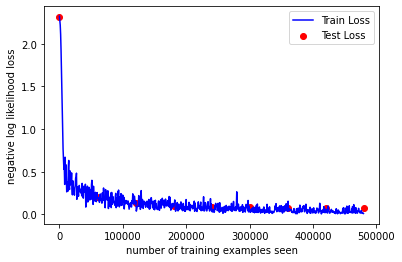

In [86]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

# Test the model and make some Predictions

In [87]:
def test_model(model,test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  # Do not compute a gradient
  with torch.no_grad():
    for data, target in test_loader:
     # Reshape data to [1000,784] Tensor: https://stackoverflow.com/questions/54916135/what-is-the-class-definition-of-nn-linear-in-pytorch
      data = data.view(data.shape[0], -1)
      # label data: Put the test dataset into the model and let it get labeled
      output = model(data)
      test_loss += F.nll_loss(output,target,reduction='sum').item()
      # Get prediction from labeld data
      pred = output.data.max(1, keepdim=True)[1]
      # count how many were correct
      correct += pred.eq(target.data.view_as(pred)).sum()
  # log test_loss
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [88]:
test_model(model=dnn,test_loader=test_loader)


Test set: Avg. loss: 0.0747, Accuracy: 9759/10000 (98%)



In [89]:
# Label the test_data set 
with torch.no_grad():
  #print(img_test_data.shape)
  # Reshape data to [1000,784] Tensor: https://stackoverflow.com/questions/54916135/what-is-the-class-definition-of-nn-linear-in-pytorch
  data = img_test_data.view(img_test_data.shape[0], -1)
  output = dnn(data)

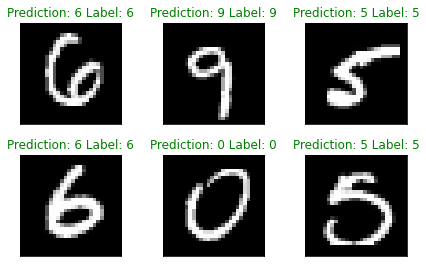

In [90]:
# plot some predictions from the test dataset
# First 6 predictions from actual example_test iteration step
fig = plt.figure()
k=30
#print(test_data[4+k][0].numpy()) # Get numpy array for data
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(img_test_data[i+k][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {} Label: {}".format(
    output.data.max(1, keepdim=True)[1][i+k].item(),label_test_data[i+k]),color="green")
  plt.xticks([])
  plt.yticks([])


# Save the Model

In [91]:
#torch.save(cnn, './data/model.pth')
torch.save(dnn.state_dict(), './data/dnn_model.pth')